<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. 增加训练数据量
2. 增加模型复杂度
3. 增加epochs

标准答案：
1.Add more layers/units to your model (increase model complexity). This will potentially give the model more of an opportunity to learn generalizable patterns in the training data. For example, instead of using 2 hidden layers, use 4 hidden layers instead.
2.Use transfer learning. Transfer leanring helps to prevent underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.
3.Train the model for longer. Perhaps your initial training schedule didn't give your model enough opportunity to learn patterns in the data. Training your model for longer (more epochs) may give improved results.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests 
import zipfile 
from pathlib import Path 

# setup path to data folder 
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} dir exists.")
else:
    print(f"{image_path} dir is not exists.")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data (images from GitHub)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"Unzipping pizza, steak, suhsi data to {image_path}")
        zip_ref.extractall(image_path) 

data/pizza_steak_sushi dir exists.


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg')]
data/pizza_steak_sushi/train/pizza/1089334.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/1089334.jpg
Image class: pizza
Image height: 288
Image width: 512


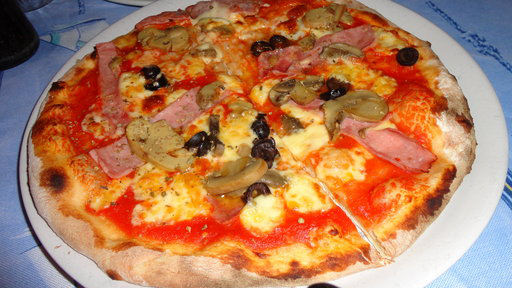

In [7]:
# Visualize an image

import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

# 2. Get random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img
# Image.open("/content/data/pizza_steak_sushi/test/pizza/194643.jpg")



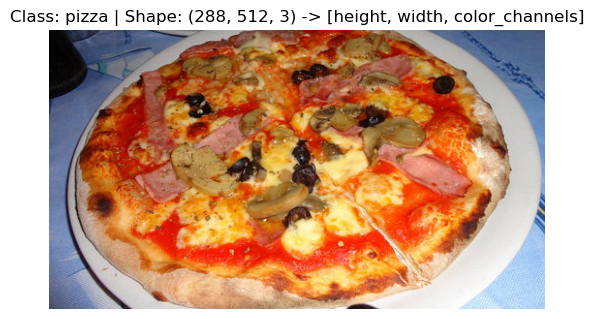

In [11]:
# Do the image visualization with matplotlib

import matplotlib.pyplot as plt
import numpy as np 

image_as_array = np.asarray(img)

plt.imshow(image_as_array)
plt.title(f"Class: {image_class} | Shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [12]:
# 3.1 Transforming data with torchvision.transforms
import torch 
from torchvision import transforms 
from torch.utils.data import DataLoader 

In [13]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])

In [14]:
random.sample(image_path_list, 4)

[PosixPath('data/pizza_steak_sushi/train/steak/2614649.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2992084.jpg')]

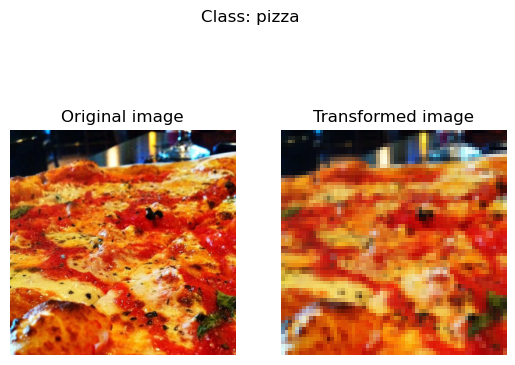

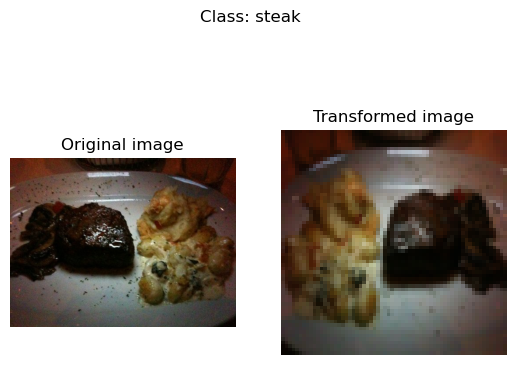

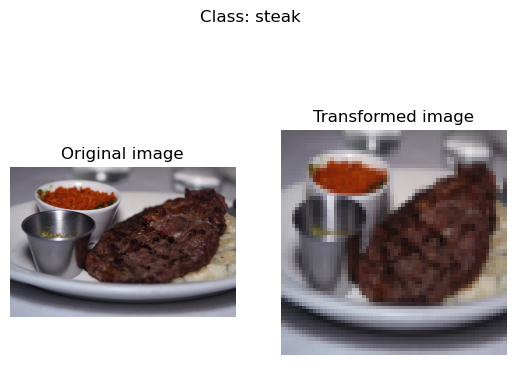

In [15]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a transformed image from a random image path."""
    random.seed(seed)
    # Get a random image path
    random_image_path = random.sample(image_paths, n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original image")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image")
            ax[1].axis(False)


            fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_path_list, transform=data_transform)

### Load image data using `ImageFolder`

In [16]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)   

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [24]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 1
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16b078500>,
 <torch.utils.data.dataloader.DataLoader at 0x16b07b7d0>)

In [25]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [27]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [28]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [29]:
# pass dummy data through the model 

dummpy = torch.randn(1, 3, 64, 64).to(device)
model_0(dummpy)

tensor([[ 0.0339,  0.0007, -0.0151]], grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [30]:
def train_step(model: torch.nn.Module,
 dataloader: torch.utils.data.DataLoader,
 loss_fn: torch.nn.Module,
 optimizer: torch.optim.Optimizer):
 
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad 
        optimizer.zero_grad()

        # 4. Loss backward 
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and average accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
 dataloader: torch.utils.data.DataLoader,
 loss_fn: torch.nn.Module):
 
 # Put model in eval mode
 model.eval()

 # Setup the test loss and test accuracy values
 test_loss, test_acc = 0, 0

 # Turn on inference context manager
 with torch.inference_mode():
    for X, y in dataloader:
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate accuracy
        test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
        test_acc += (test_pred_labels == y).sum().item()/len(y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [32]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
 train_dataloader: torch.utils.data.DataLoader,
 test_dataloader: torch.utils.data.DataLoader,
 optimizer: torch.optim.Optimizer,
 loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
 epochs: int = 5):
 
 # Create results dictionary
 results = {"train_loss": [],
 "train_acc": [],
 "test_loss": [],
 "test_acc": []}

 # Loop through the training and testing steps for a number of epochs
 for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
    dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
    dataloader=test_dataloader,
    loss_fn=loss_fn)
 
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
    f"train_loss: {train_loss:.4f} | "
    f"train_acc: {train_acc:.4f} | "
    f"test_loss: {test_loss:.4f} | "
    f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

 # Return the results dictionary
 return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [34]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)


model_0_results = train(model=model_0,
 train_dataloader=train_dataloader,
 test_dataloader=test_dataloader,
 optimizer=optimizer,
 loss_fn=loss_fn,
 epochs=5)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1191 | train_acc: 0.2800 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1017 | train_acc: 0.3111 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3244 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3244 | test_loss: 1.1000 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.1005 | test_acc: 0.3333


In [35]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1191 | train_acc: 0.2800 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1017 | train_acc: 0.3111 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3244 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3244 | test_loss: 1.1000 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0987 | train_acc: 0.3600 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1019 | test_acc: 0.3333
Epoch: 12 | train_l

In [36]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1191 | train_acc: 0.2800 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1017 | train_acc: 0.3111 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3244 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3244 | test_loss: 1.1000 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0987 | train_acc: 0.3600 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1019 | test_acc: 0.3333
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi 20% data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
 transforms.Resize((64, 64)), 
 transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?